In [158]:
import HierPortfolios as hp
import pandas as pd
import numpy as np
import re
import datetime

In [159]:
df = pd.read_excel("data/ibrx_mensal.xlsx", na_values="-")


In [160]:
df.head(10)

,Data,RRRP3,ALPA4,ABEV3,AMER3,ASAI3,AZUL4,B3SA3,IDI11,BPAN4,...,TIMS3,TOTS3,UGPA3,USIM5,VALE3,VIIA3,VBBR3,WEGE3,YDUQ3,IBOV
0,Dez-1967,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Jan-1968,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.000000
2,Fev-1968,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.953271
3,Mar-1968,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.943089
4,Abr-1968,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.388060
5,Mai-1968,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.536585
6,Jun-1968,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-8.426966
7,Jul-1968,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.613497
8,Ago-1968,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.086420
9,Set-1968,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.377246


In [161]:
# transforming the 'Data' column to a date format
df['Data'] = df['Data'].str.replace('Jan', '01').str.replace('Fev', '02').str.replace('Mar', '03').str.replace('Abr', '04').str.replace('Mai', '05').str.replace('Jun', '06').str.replace('Jul', '07').str.replace('Ago', '08').str.replace('Set', '09').str.replace('Out', '10').str.replace('Nov', '11').str.replace('Dez', '12')
df['Data'] = pd.to_datetime(df['Data'], format='%m-%Y')

In [162]:
df = df[(df['Data'] >= '2000-01-01') & (df['Data'] <= '2020-02-01')]

# replacing NA values with 0
df = df.dropna(axis=1)


In [163]:
df.columns

Index(['Data', 'ALPA4', 'ABEV3', 'BBDC3', 'BBDC4', 'BBAS3', 'BRKM5', 'CMIG4',
       'CPLE6', 'ELET3', 'ELET6', 'EMBR3', 'EGIE3', 'GGBR4', 'GOAU4', 'ITSA4',
       'ITUB4', 'LIGT3', 'PETR3', 'PETR4', 'SBSP3', 'CSNA3', 'VIVT3', 'TIMS3',
       'USIM5', 'VALE3', 'IBOV'],
      dtype='object')

In [164]:
# this one include pandas

import numpy as np
import pandas as pd
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, leaves_list


def HRP_Portfolio(df, linkage_method="single", graph=False):
    if linkage_method not in ["single", "complete", "average", "ward"]:
        return "ERROR: linkage_method argument only supports 'single', 'complete', 'average' or 'ward' options"
    if linkage_method == "ward":
        linkage_method = "ward.D2"
    
    # Stage 1: Tree clustering
    corr = df.corr()
    distance = np.sqrt(0.5 * (1 - corr))
    euclidean_distance = squareform(pdist(distance, metric="euclidean"))
    
    # Stage 2: Quasi-Diagonalisation
    clustering = linkage(euclidean_distance, method=linkage_method)
    clusters_order = leaves_list(clustering)
    
    # Stage 3: Recursive Bisection
    weights = np.ones(df.shape[1])
    index = [clusters_order.tolist()]
    while len(index) > 0:
        new_index = []
        for i in index:
            middle = len(i) // 2
            indexa = i[:middle]
            indexb = i[middle:]
            covar_clustera = df.iloc[:, indexa].iloc[indexa, :]
            covar_clusterb = df.iloc[:, indexb].iloc[indexb, :]
            weightsa = 1 / np.diag(covar_clustera)
            weightsa /= np.sum(weightsa)
            weightsb = 1 / np.diag(covar_clusterb)
            weightsb /= np.sum(weightsb)
            variance_clustera = np.dot(weightsa, np.dot(covar_clustera, weightsa))
            variance_clusterb = np.dot(weightsb, np.dot(covar_clusterb, weightsb))
            alpha = 1 - variance_clustera / (variance_clustera + variance_clusterb)
            weights[indexa] *= alpha
            weights[indexb] *= (1 - alpha)
            if len(indexa) > 1:
                new_index.append(indexa)
            if len(indexb) > 1:
                new_index.append(indexb)
        index = new_index
    
    if graph:
        import matplotlib.pyplot as plt
        from scipy.cluster.hierarchy import dendrogram
        
        plt.figure(figsize=(10, 7))
        plt.xlabel("Stocks")
        plt.ylabel("Distance")
        plt.title("Cluster Dendrogram - HRP")
        column_names = list(df.columns)
        dendrogram(clustering, leaf_rotation=90, leaf_font_size=8, labels=column_names)
        plt.show()


    
    return weights


C:\Users\felip\AppData\Local\Temp\ipykernel_14620\4292916302.py:21: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  clustering = linkage(euclidean_distance, method=linkage_method)


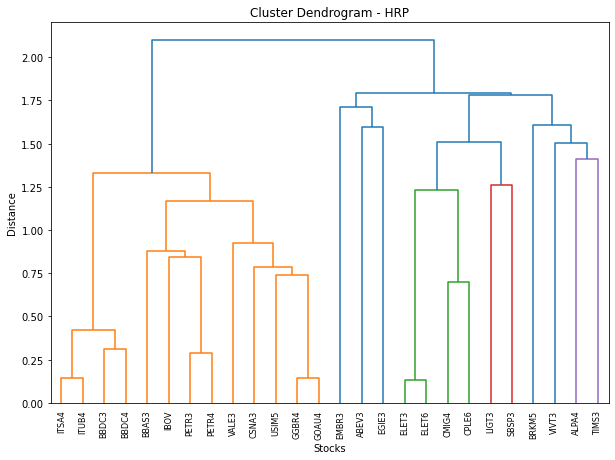

array([0.04286631, 0.11464672, 0.02300753, 0.04579503, 0.01755369,
       0.03093894, 0.03640913, 0.05747627, 0.02798097, 0.02331535,
       0.06981978, 0.07200532, 0.01331205, 0.01148504, 0.05064624,
       0.02604366, 0.02557066, 0.03283838, 0.02205205, 0.04039612,
       0.01076784, 0.08371427, 0.03186615, 0.00879485, 0.02818454,
       0.0525131 ])

In [165]:
df_numeric = df.select_dtypes(include=['float64', 'int64'])

df_cov = df_numeric.cov()
HRP_Portfolio(df_cov, graph=True)

In [166]:
def rolling_window_HRP(data, window_size):
    """
    This function applies the Hierarchical Risk Parity algorithm to a rolling window of historical returns.

    Parameters:
    data (DataFrame): Historical returns with dates in a column.
    window_size (int): The size of the rolling window.

    Returns:
    DataFrame: A dataframe with the realized returns, HRP returns and MV returns for each out-of-sample window.
    """
    data.set_index('Data', inplace=True)
    num_windows = len(data) - window_size + 1
    realized_returns = np.zeros(num_windows)
    HRP_returns = np.zeros(num_windows)
    MV_returns = np.zeros(num_windows)
    for i in range(num_windows):
        window = data.iloc[i:i+window_size, :]
        realized_returns[i] = np.prod(1 + window.mean(axis=0)) - 1
        covar = np.cov(window, rowvar=False)
        weights_HRP = get_HRP_weights(covar)
        HRP_returns[i] = (weights_HRP * window.mean(axis=0)).sum()
        weights_MV = get_MV_weights(covar)
        MV_returns[i] = (weights_MV * window.mean(axis=0)).sum()
    result = pd.DataFrame({
        'Realized Returns': realized_returns,
        'HRP Returns': HRP_returns,
        'MV Returns': MV_returns
    })
    return result


In [200]:
import pandas as pd
import numpy as np

def min_var_portfolio(cov):
    inv_cov = np.linalg.inv(cov)
    ones = np.ones(len(cov))
    return np.dot(inv_cov, ones) / np.dot(np.dot(ones, inv_cov), ones)


def rolling_window_HRP(data, window_size):
    
    """
    This function applies the Hierarchical Risk Parity algorithm to a rolling window of historical returns.

    Parameters:
    data (DataFrame): Historical returns with dates in a column.
    window_size (int): The size of the rolling window.

    Returns:
    DataFrame: A dataframe with the realized returns, HRP returns and MV returns for each out-of-sample window.
    """

    number_of_rows = len(data)  # number of rows
    number_of_columns = len(data.columns)  # number of columns
    weights = np.empty((number_of_rows - 1, number_of_columns - 1))  # matrix to save weights
    weights_mv = np.empty((number_of_rows - 1, number_of_columns - 1))  # matrix to save weights for MV
    out_of_sample = number_of_rows - window_size  # out of sample size
    Rport = np.empty((out_of_sample, 3))  # matrix to save returns, 3 columns to store date and returns comparing with HRP and MV
    
    for i in range(out_of_sample):
        df_rolling = data.iloc[i:i + window_size, 1:]
        df_cov = df_rolling.cov().values
        weights[i, :] = HRP_Portfolio(df_cov, graph=False)
        weights_mv[i, :] = min_var_portfolio(df_cov)
        Rport[i, 0] = data.iloc[i + window_size, 0]  # date
        Rport[i, 1] = np.mean(data.iloc[i + window_size, 1:])  # realized return for the period
        Rport[i, 2] = np.dot(weights[i, :], data.iloc[i + window_size, 1:])  # realized cumulative return for the period for HRP
        Rport[i, 3] = np.dot(weights_mv[i, :], data.iloc[i + window_size, 1:])  # realized cumulative return for the period for MV
    
    Rport = pd.DataFrame(Rport, columns=["Date", "Equal Weights", "HRP", "MV"])  # column names
    Rport["Date"] = pd.to_datetime(Rport["Date"])
    
    return Rport

report = rolling_window_HRP(df_cov, 25)
report

AttributeError: 'numpy.ndarray' object has no attribute 'corr'

In [191]:
window_size = 60
number_of_rows = len(df_cov)  # number of rows
number_of_columns = len(df_cov.columns)  # number of columns


weights = np.empty((number_of_rows - 1, number_of_columns - 1))  # matrix to save weights
weights_mv = np.empty((number_of_rows - 1, number_of_columns - 1))  # matrix to save weights for MV
out_of_sample = number_of_rows - window_size  # out of sample size
Rport = np.empty((out_of_sample, 3))  # matrix to save returns, 3 columns to store date and returns comparing with HRP and MV


ValueError: negative dimensions are not allowed

In [198]:
number_of_rows - 3

23

In [172]:
rolling_window_HRP(df_cov, 60)

ValueError: negative dimensions are not allowed